In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scienceplots
import scipy.stats as st
plt.style.use(['science', 'grid'])
# plt.rcParams['text.latex.preamble'] = r'''
#     # \usepackage[T1]{fontenc}
#     # \usepackage{XCharter}
#     # \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
# '''

plt.rcParams['text.latex.preamble'] = r'''
        \usepackage[T1]{fontenc}
        \usepackage{newtxtext,newtxmath}
    '''

import os
import sys
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dynamic_tasker.access import *
from dynamic_tasker.orbits import *
from dynamic_tasker.constants import *
from dynamic_tasker.cameras import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.rotations import *
from tqdm import tqdm

%load_ext autoreload
%autoreload 2


In [ ]:
# Generate a schedule...
h = 400
# os.chdir("./exploration")
requests = load_worldcities(10000)
t0 = datetime.datetime(2024, 1, 1, 12, 0, 0)
orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi - 0.05, M=np.pi/2, t=t0)
t_end = datetime.datetime(2024, 1, 1, 12, 17, 0)
accesses = get_accesses(requests, orbit, 500, 30, t0, t_end)
width=800
height=600
t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))



/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T


In [3]:
schedule = milp_schedule(accesses, requests, agility_bangbang)
# Calculate tasks/sec
tasks_per_sec = len(schedule) / (t_end - t0).total_seconds()
prob_task_good = 0.34

$$d = R \arccos\!\left(\frac{(R+h)\sin^2\theta + \cos\theta\,\sqrt{R^2 - (R+h)^2 \sin^2\theta}}{R}\right)$$


In [7]:
def ecef2pitchroll(pos_ecef, v_ecef, average_vec):
    # Unproject test    
    Up = pos_ecef / np.linalg.norm(pos_ecef)

    Along = v_ecef / np.linalg.norm(v_ecef)
    Right = np.cross(Along, Up)
    Right = Right / np.linalg.norm(Right)

    Along = np.cross(Up, Right)
    Along = Along / np.linalg.norm(Along)

    R_ecef_to_body = np.vstack([Right, Along, Up])

    v_local = R_ecef_to_body @ average_vec
    v_local_norm = v_local / np.linalg.norm(v_local)  # normalize for angle calculations

    pitch = -np.arctan2(v_local_norm[1], v_local_norm[2])
    roll  = -np.arctan2(v_local_norm[0], v_local_norm[2])

    pitch_deg = np.degrees(pitch) * 1
    roll_deg  = np.degrees(roll)

    return pitch_deg, roll_deg

def project_in_box(pitch_deg, roll_deg, orbit, K, t, accesses, points):
    # First, project and see if it's in the box
    points_eci = np.array([ecef2eci(p, t) for p in points])
    ecef_projected_dir = project_from_orbit(points_eci, K, orbit, t, pitch_angle=pitch_deg, roll_angle=roll_deg)
    # Figure out how many are in the box
    in_box_idx = np.array([i for i, p in enumerate(ecef_projected_dir) if p[0] >= 0 and p[0] <= width and p[1] >= 0 and p[1] <= height])
    return [a for i, a in enumerate(accesses) if i in in_box_idx], in_box_idx

def filter_accesses_horizon(orbit, time, accesses, pos_ecef):
    return [(r, a, t, access, idx) for r, a, t, access, idx in accesses if t >= time and t <= time + datetime.timedelta(hours=1) and dist(pos_ecef, r) < horizon_distance(orbit) and a <= 30]

# def evaluate_lookahead_all(time, orbit, accesses_current):
#     accesses_filtered = filter_accesses_horizon(orbit, time, accesses_current)
#     # Let's try evaluating on a real dataset...
#     points = np.array([r for r, _, _, _, _ in accesses_filtered])
#     idxs = np.array([i for _, _, _, _, i in accesses_filtered])
    
#     # Take the average
#     average_vec = pos_ecef - (np.mean(points, axis=0))

#     # Get the angle between that and nadir
#     nadir = -pos_ecef/np.linalg.norm(pos_ecef)
#     lookahead_angle = np.arccos(np.dot(-nadir, average_vec)/np.linalg.norm(average_vec))
#     pitch_deg, roll_deg = ecef2pitchroll(pos_ecef, v_ecef, average_vec)

#     projected_accesses, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, t, accesses_filtered, points)
#     not_observed = np.array([not accesses_filtered[i][-1].state["observed"] for i in in_box_idx]).astype(int)

#     total_unobserved_inbox = np.sum(not_observed)
#     reward = total_unobserved_inbox * 1
#     action=(pitch_deg, roll_deg)

#     return action, reward

def analytic_chain_probability(L, lam, M, c):
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule):
    accesses_inbox, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points)
    N = len([a for a in accesses_inbox if a[-2].state["observed"] == False]) * 0.34
    adv = 0
    if(N > 0):
        t_total = np.max([a[2] for a in accesses_inbox]) - np.min([a[2] for a in accesses_inbox])
        t_gap = agility_bangbang(45)

        if(t_total.total_seconds() > 0):
            adv = expected_advantage(N, t_total.total_seconds(), t_gap, 2, 40)

    # Now calculate cost...
    # Check how many tasks in the schedul we miss
    schedule_filtered = [s for s in schedule if s.time > time and s.time <= time + datetime.timedelta(hours=1)]
    # Total lookahead maneuver time
    # No setting time for lookahead
    # Assume 35 deg boresight angle
    t_maneuver = 2 * (agility_bangbang(pitch_deg - 35)) - agility_bangbang(0)

    schedule_missed = [s for s in schedule_filtered if time + datetime.timedelta(seconds=t_maneuver) > s.time]

    cost = len(schedule_missed) * 0.34
    utility = adv - cost
    missed = len(schedule_missed)
    return accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver

def evaluate_lookahead_chain(time, orbit, schedule, accesses, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)

    accesses_filtered = filter_accesses_horizon(orbit, time, accesses, pos_ecef)
    min_time = agility_bangbang(45)
    accesses_filtered = [a for a in accesses_filtered if a[-2].time > time + datetime.timedelta(seconds=min_time)]
    # Let's do a test to figure out what the heuristic will do best at...
    idxs = np.array([i for _, _, _, _, i in accesses_filtered])

    roll_deg = 0
    pitch_degs = np.linspace(0, 70)

    expected_utilities = []
    expected_advantages = []
    expected_costs = []
    for pitch_deg in pitch_degs:
        _, _, utility, adv, cost, _, _ = actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)
        
        expected_utilities.append(utility)
        expected_advantages.append(adv)
        expected_costs.append(cost)

    # Find the maximum advantage
    max_adv = np.max(expected_utilities)
    max_idx = np.argmax(expected_utilities)
    # Find the pitch angle that gives the maximum advantage
    best_pitch_deg = pitch_degs[max_idx]

    # Recalculate in box
    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(best_pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)

    mapped_in_box_idx = [idxs[i] for i in in_box_idx]
    # Recalculate utility

    return ((best_pitch_deg, roll_deg), mapped_in_box_idx, expected_utilities, expected_advantages, expected_costs, utility, adv, cost, missed, t_maneuver)



def roll2crosstrack(angle, h):
    R = Constants.R_E
    theta = np.radians(angle)
    return np.sign(theta) *  R * np.arccos(((R + h) * (np.sin(theta)) ** 2 + np.cos(theta) * np.sqrt(R**2 - ((R + h)**2) * (np.sin(theta) ** 2)))/(R))

def subtending_angle_from_fov(fov, h):
    sign = np.sign(fov)
    angle = np.abs(fov)
    beta = np.pi - np.arcsin((Constants.R_E + h)/(Constants.R_E) * np.sin(angle)) # obtuse angle
    
    theta = np.pi - (angle + beta)
    return theta * sign

def accesses2track(accesses, orbit, t0, t_end):
    v_orbit = v_orb(orbit.a - Constants.R_E)
    # Along, across...
    track = [(a.time - t0).total_seconds() * v_orbit for a in accesses]
    roll2cr = [roll2crosstrack(a.angle, orbit.a - Constants.R_E) for a in accesses]
    
    return track, roll2cr

for a in accesses:
    a.state = {"observed": False}



  0%|          | 0/1 [00:00<?, ?it/s]/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T
  0%|          | 0/1 [00:09<?, ?it/s]

45 14


IndexError: index 441 is out of bounds for axis 0 with size 441

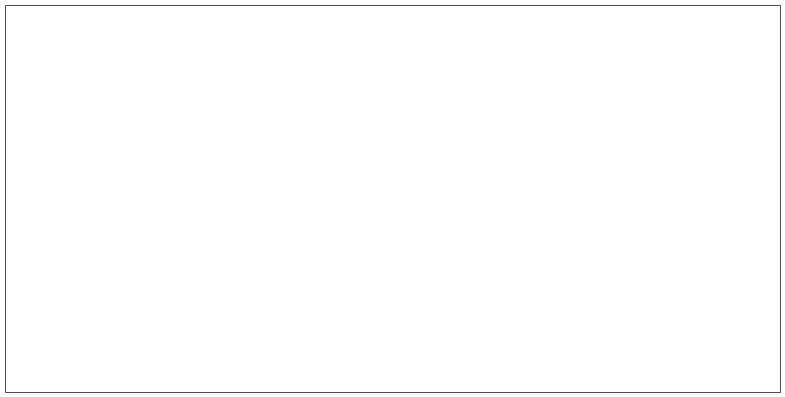

In [8]:
N = 1

omni_schedule_perf = []
initial_schedule_perf = []
dt_schedule_perf = []

# Create high resolution box with 20 points per edge
box_hires = create_box(width, height, points_per_edge=12)

for i in tqdm(range(N)):
    for a in accesses:
        a.state = {"observed": False, "cloudy": np.random.rand() < 0.66}

    schedule = milp_schedule(accesses, requests, agility_bangbang)
    schedule_omni = milp_schedule([a for a in accesses if not a.state["cloudy"]], requests, agility_bangbang)

    print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))
    initial_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))
    omni_schedule_perf.append((len(schedule_omni), len([s for s in schedule_omni if not s.state["cloudy"]])))

    # K = get_intrinsics(800, width//2, height//2)
    K = get_intrinsics_from_fov(45, width, height)

    if(N == 1):
        fig = plt.figure(figsize=(10, 10))
        # Create a cartopy GeoAxes with PlateCarree projection
        ax = plt.axes(projection=ccrs.PlateCarree())
        lookahead_plotted=False

    utilities, advs, costs = [], [], []
    i = 0
    while(i < len(schedule)):
        s = schedule[i]
        t = s.time
        # Convert all accesses to ECEF
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]
        points = np.array([r for r, _, _, _, _ in accesses_converted])

        # Get current orbit position in ECEF
        orbit_new = propagate_orbit(orbit, t)
        r , v = kepler2eci(orbit_new)
        # pos_ecef = eci2ecef(r, t)
        v_ecef = eci2ecef(v, t)
        
        lookahead_action, in_box_idx, all_utilities, all_advs, all_costs, utility, adv, cost, missed, maneuver_time = evaluate_lookahead_chain(t, orbit_new, schedule, accesses_converted, K)
        lookahead_reward = utility
        utilities.append(all_utilities)
        advs.append(all_advs)
        costs.append(all_costs)

        pitch_deg, roll_deg = lookahead_action

        # For plotting
        ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg))
        # Calculate Earth line intersections in ECI
        
        eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
        # Convert to latlong
        latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]
        if(lookahead_reward > 0):
            # Mark the accesses as observed
            for j in in_box_idx:
                accesses[accesses_converted[j][-1]].state["observed"] = True
            
            # Plot the lookahead
            if(N==1):
                plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label='Lookahead' if not lookahead_plotted else None)
                lookahead_plotted = True

            # TODO: Re-optimize the schedule...
            min_time = t
            max_time = np.max([a[2] for a in accesses_converted if a[-2].state["observed"]])


            accesses_in_time = [a for a in accesses if a.time >= min_time + datetime.timedelta(seconds=maneuver_time) and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])] 
            # Make sure to add the bounding accesses
            if(schedule[i] not in accesses_in_time):
                accesses_in_time.insert(0, schedule[i])

            max_bounding = [(i, s) for i, s in enumerate(schedule) if s.time >= max_time][0]
            max_bounding_schedule_idx, max_bounding_schedule = max_bounding[0], max_bounding[1]
            if(max_bounding_schedule not in accesses_in_time):
                accesses_in_time.append(max_bounding_schedule)

            # Re-optimize the schedule, force in the bounding accesses
            # print([schedule[i], max_bounding_schedule])
            try:
                schedule_slice_optimized = milp_schedule(accesses_in_time, requests, agility_bangbang, [schedule[i], max_bounding_schedule])
            except Exception as e:
                print(e, [schedule[i], max_bounding_schedule], len(accesses_in_time))
            
            # Update the schedule
            schedule = schedule[:i] + schedule_slice_optimized[1:-1] + schedule[max_bounding_schedule_idx:]
        i += 1

    dt_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))

print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))

# Plot accesses
plt.plot([a.long for a in accesses if a.state["observed"]], [a.lat for a in accesses if a.state["observed"]], 'b.', transform=ccrs.PlateCarree(), label='Observed Accesses', markersize=5)
plt.plot([a.long for a in accesses if not a.state["observed"]], [a.lat for a in accesses if not a.state["observed"]], 'm.', transform=ccrs.PlateCarree(), label='Unobserved Accesses', markersize=5)
plt.plot([r.long for r in requests if r not in [x.request for x in accesses]], [r.lat for r in requests if r not in [x.request for x in accesses]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong = [kepler2latlong(propagate_orbit(orbit, t), orbit.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong], [lat for lat, long in orbit_latlong], 'k-', label='Orbit Track')

# Show the start and end latlong
orbit_latlong_start = kepler2latlong(propagate_orbit(orbit, 0), t0)
orbit_latlong_end = kepler2latlong(propagate_orbit(orbit, (t_end - t0).total_seconds()), t_end)
print(orbit_latlong_start)
print(orbit_latlong_end)
plt.plot([orbit_latlong_start[1]], [orbit_latlong_start[0]], 'g*', transform=ccrs.PlateCarree(), label='Start', markersize=10)
plt.plot([orbit_latlong_end[1]], [orbit_latlong_end[0]], 'r*', transform=ccrs.PlateCarree(), label='End', markersize=10)

# Add coastlines
ax.stock_img(alpha=0.3)
ax.coastlines()
ax.set_extent([-15, 65, 15, 60], crs=ccrs.PlateCarree())
ax.legend(frameon=True, ncol=2)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.savefig('lookahead_chain.png', dpi=300)
plt.show()

In [6]:
# Check for duplicates in schedule
# for i, s in enumerate(schedule):
#     print(s.requestid)

# Check that they all follow agi\lity constraints
for i in range(len(schedule) - 1):
    # print((schedule[i+1].time - schedule[i].time).total_seconds(), agility_bangbang(schedule[i].angle - schedule[i+1].angle))
    if((schedule[i+1].time - schedule[i].time).total_seconds() < agility_bangbang(schedule[i].angle - schedule[i+1].angle)):
        print(f"Warning: Schedule does not follow agility constraints at {schedule[i].name} and {schedule[i+1].name}")


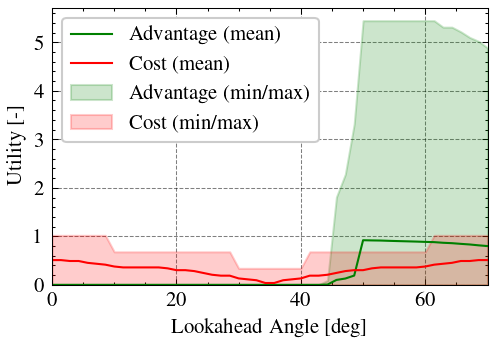

In [61]:
# Plot some costs, utilities
fig = plt.figure(figsize=(3.5, 2.5), dpi=150)

angles = np.linspace(0, 70)

# plt.plot(np.mean(utilities, axis=0), label='Utility', color='blue')
plt.plot(angles, np.mean(advs, axis=0), label='Advantage (mean)', color='green')
plt.plot(angles, np.mean(costs, axis=0), label='Cost (mean)', color='red')
plt.plot([])

# Plot the min and max of each
# plt.fill_between(range(len(utilities[0])), np.min(utilities, axis=0), np.max(utilities, axis=0), color='blue', alpha=0.2)
plt.fill_between(angles, np.min(advs, axis=0), np.max(advs, axis=0), color='green', alpha=0.2, label='Advantage (min/max)')
plt.fill_between(angles, np.min(costs, axis=0), np.max(costs, axis=0), color='red', alpha=0.2 , label='Cost (min/max)')

plt.legend()
plt.xlim(0, 70)
plt.ylim(0)
plt.xlabel('Lookahead Angle [deg]')
plt.ylabel('Utility [-]')
plt.tight_layout()
plt.savefig('lookahead_adv_cost.pdf')
plt.show()


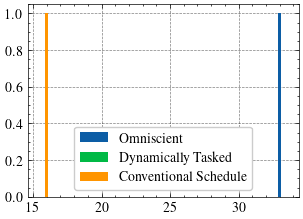

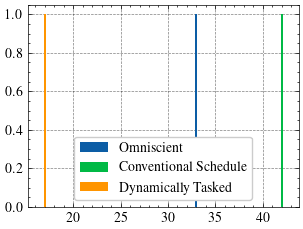

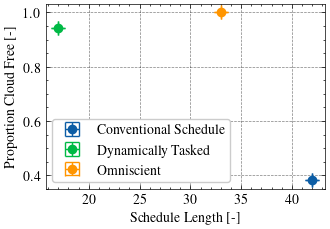

In [8]:
# Make a histogram plot
plt.figure(figsize=(3.5, 2.5))
n_bins = 5
plt.hist([x[1] for x in omni_schedule_perf], label='Omniscient', bins=n_bins)
plt.hist([x[1] for x in dt_schedule_perf], label='Dynamically Tasked', bins=n_bins)
plt.hist([x[1] for x in initial_schedule_perf], label='Conventional Schedule', bins=n_bins)
plt.legend()
plt.show()

# Now for schedule length
plt.hist([x[0] for x in omni_schedule_perf], label='Omniscient', bins=n_bins)
plt.hist([x[0] for x in initial_schedule_perf], label='Conventional Schedule', bins=n_bins)
plt.hist([x[0] for x in dt_schedule_perf], label='Dynamically Tasked', bins=n_bins)
plt.legend()
plt.show()

# Now figure out the error bars

# Calculate proportion cloud free
cloud_free_omni = [x[1]/x[0] for x in omni_schedule_perf]
cloud_free_initial = [x[1]/x[0] for x in initial_schedule_perf]
cloud_free_dt = [x[1]/x[0] for x in dt_schedule_perf]

# Error bars
cloud_free_omni_err = np.std(cloud_free_omni)
cloud_free_initial_err = np.std(cloud_free_initial)
cloud_free_dt_err = np.std(cloud_free_dt)

# Cloud free centroids
cloud_free_omni_centroid = np.mean(cloud_free_omni)
cloud_free_initial_centroid = np.mean(cloud_free_initial)
cloud_free_dt_centroid = np.mean(cloud_free_dt)


# Schedule length error bars
schedule_length_omni_err = np.std([x[0] for x in omni_schedule_perf])
schedule_length_initial_err = np.std([x[0] for x in initial_schedule_perf])
schedule_length_dt_err = np.std([x[0] for x in dt_schedule_perf])

# Schedule length centroids
schedule_length_omni_centroid = np.mean([x[0] for x in omni_schedule_perf])
schedule_length_initial_centroid = np.mean([x[0] for x in initial_schedule_perf])
schedule_length_dt_centroid = np.mean([x[0] for x in dt_schedule_perf])

# Plot the centroids and error bars for all
plt.figure(figsize=(3.5, 2.5))
plt.errorbar(schedule_length_initial_centroid, cloud_free_initial_centroid,
             xerr=schedule_length_initial_err, yerr=cloud_free_initial_err,
             fmt='o', label='Conventional Schedule', capsize=5)
plt.errorbar(schedule_length_dt_centroid, cloud_free_dt_centroid,
             xerr=schedule_length_dt_err, yerr=cloud_free_dt_err,
             fmt='o', label='Dynamically Tasked', capsize=5)
plt.errorbar(schedule_length_omni_centroid, cloud_free_omni_centroid,
             xerr=schedule_length_omni_err, yerr=cloud_free_omni_err,
             fmt='o', label='Omniscient', capsize=5)

plt.xlabel('Schedule Length [-]')
plt.ylabel('Proportion Cloud Free [-]')
plt.legend()
plt.tight_layout()
plt.savefig("smallsat_schedule_perf.pdf")
plt.show()



In [9]:
# Comparisons

# Compare how much better the DT is than the conventional schedule
improved = [x[1]/y[1] for x, y in zip(dt_schedule_perf, initial_schedule_perf)]
print(np.mean(improved))
print(np.max(improved))
print(np.min(improved))

improved_bool = [x[1] > y[1] for x, y in zip(dt_schedule_perf, initial_schedule_perf)]
print(improved_bool)
print(np.mean(improved_bool))

# Compare how much shorter the DT is than the omniscient
shorter = [x[0]/y[0] for x, y in zip(dt_schedule_perf, omni_schedule_perf)]

print(np.mean(shorter))




1.0
1.0
1.0
[False]
0.0
0.5151515151515151


In [17]:
# Make it so the follower is 10 mins behind

orbit_leader = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi - 0.05, M=np.pi/2, t=t0)
orbit_follower = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi - 0.05, M=0, t=t0)

print(orbit_leader)
print(orbit_follower)
# Now schedule a constellation...
accesses_leader = get_accesses(requests, orbit_leader, 500, 30, t0, t_end)
accesses_follower = get_accesses(requests, orbit_follower, 500, 30, t0, t_end + datetime.timedelta(minutes=30))

# Try and schedule a constellation...
schedule = milp_schedule_constellation([accesses_leader, accesses_follower], requests, agility_bangbang)


Keplerian(a=6778, e=0, i=0.9005898940290741, omega=0, Omega=3.0915926535897933, M=1.5707963267948966, t=datetime.datetime(2024, 1, 1, 12, 0))
Keplerian(a=6778, e=0, i=0.9005898940290741, omega=0, Omega=3.0915926535897933, M=0, t=datetime.datetime(2024, 1, 1, 12, 0))


In [18]:
print(len(schedule[1]))

37


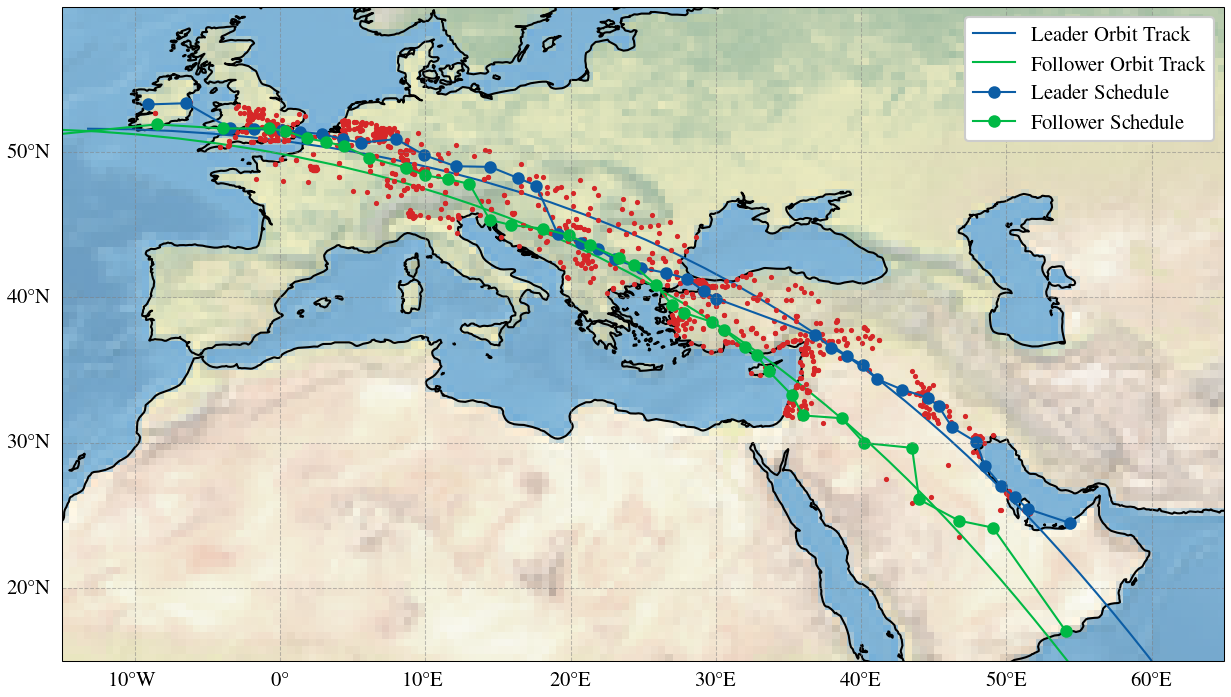

In [19]:
schedule_leader = schedule[0]
schedule_follower = schedule[1]

for i in range(len(schedule_leader)):
    for j in range(len(schedule_follower)):
        if(schedule_leader[i].name == schedule_follower[j].name):
            print(schedule_leader[i].name)
            print(schedule_leader[i].time)
            print(schedule_follower[j].time)
            print(schedule_leader[i].angle)
            print(schedule_follower[j].angle)
            print(schedule_leader[i].utility)
            print(schedule_follower[j].utility)
            print(schedule_leader[i].requestid)
            print(schedule_follower[j].requestid)

# Assert that agility requirements are met
for k in schedule:
    for i in range(len(k) - 1):
        for j in range(i + 1, len(k)):
            if(k[j].time <  k[i].time + datetime.timedelta(seconds=agility_bangbang(k[j].angle - k[i].angle))):
                print(f"Warning: Agility requirements not met for {k[i].name} and {k[j].name}")

# Plot the schedules on a map

plt.figure(figsize=(10, 10), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plto the orbit track
orbit_latlong_leader = [kepler2latlong(propagate_orbit(orbit_leader, t), orbit_leader.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end + datetime.timedelta(minutes=30) - t0).total_seconds(), 100)]
orbit_latlong_follower = [kepler2latlong(propagate_orbit(orbit_follower, t), orbit_follower.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end + datetime.timedelta(minutes=30) - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong_leader], [lat for lat, long in orbit_latlong_leader], '-', label='Leader Orbit Track', color=colors[0])
plt.plot([long for lat, long in orbit_latlong_follower], [lat for lat, long in orbit_latlong_follower], '-', label='Follower Orbit Track', color=colors[1])

# Plot all the accesses not in the schedule
plt.plot([a.long for a in accesses_leader if a not in schedule[0]], [a.lat for a in accesses_leader if a not in schedule[0]], '.', transform=ccrs.PlateCarree(), color='tab:red', markersize=3)
plt.plot([a.long for a in accesses_follower if a not in schedule[1]], [a.lat for a in accesses_follower if a not in schedule[1]], '.', transform=ccrs.PlateCarree(), color='tab:red', markersize=3)

plt.plot([a.long for a in schedule[0]], [a.lat for a in schedule[0]], 'o-', markersize=5, transform=ccrs.PlateCarree(), 
               label=f'Leader Schedule')
plt.plot([a.long for a in schedule[1]], [a.lat for a in schedule[1]], 'o-', markersize=5, transform=ccrs.PlateCarree(), 
               label=f'Follower Schedule')

# Add map features
ax.stock_img()
ax.coastlines()
ax.set_extent([-15, 65, 15, 60], crs=ccrs.PlateCarree())
# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.legend()
plt.show()



2024-01-01 12:00:00
2024-01-01 12:00:39.550781
2024-01-01 12:01:04.941406
2024-01-01 12:01:37.167969
2024-01-01 12:01:53.769531
2024-01-01 12:02:12.324219
2024-01-01 12:02:25.019531
2024-01-01 12:02:40.644531
2024-01-01 12:02:56.269531
2024-01-01 12:03:08.964844
2024-01-01 12:03:32.402344
2024-01-01 12:03:55.839844
2024-01-01 12:04:21.230469
2024-01-01 12:04:44.667969
2024-01-01 12:05:08.105469
2024-01-01 12:05:24.707031
2024-01-01 12:06:01.816406
2024-01-01 12:06:23.300781
2024-01-01 12:06:37.949219
2024-01-01 12:06:55.527344
2024-01-01 12:07:18.964844
2024-01-01 12:07:39.472656
2024-01-01 12:07:58.027344
2024-01-01 12:08:16.582031
2024-01-01 12:08:30.253906
2024-01-01 12:10:03.027344
2024-01-01 12:10:23.535156
2024-01-01 12:10:40.136719
2024-01-01 12:10:57.714844
2024-01-01 12:11:17.246094
2024-01-01 12:11:41.660156
2024-01-01 12:12:05.097656
2024-01-01 12:12:18.769531
2024-01-01 12:12:44.160156
2024-01-01 12:13:12.480469
2024-01-01 12:13:35.917969
2024-01-01 12:14:04.238281
2024-01-

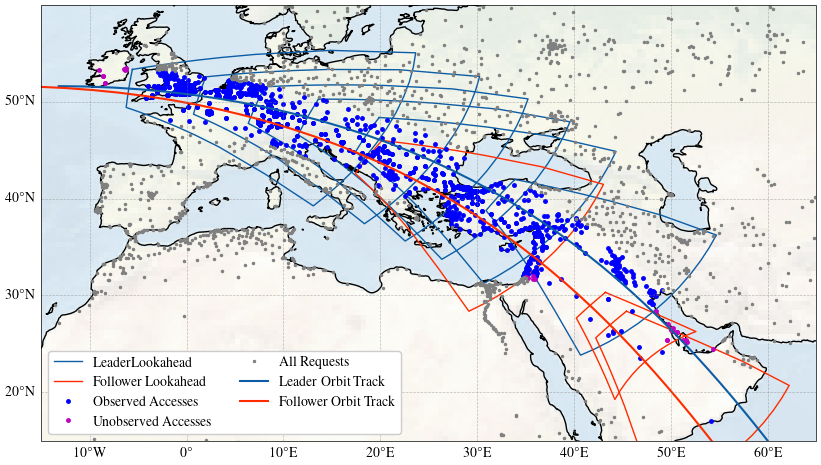

In [59]:
# Set up the DT simulation for the constellation...
current_idx = 0
time = t0
lookahead_plotted_leader = False
lookahead_plotted_follower = False

for a in accesses_leader:
    a.state = {"observed": False, "cloudy": np.random.rand() < 0.66}

for a in accesses_follower:
    # Check first if it's in the leader's access list
    if(a in accesses_leader):
        a.state = accesses_leader[accesses_leader.index(a)].state
    else:
        a.state = {"observed": False, "cloudy": np.random.rand() < 0.66}

schedule_all = milp_schedule_constellation([accesses_leader, accesses_follower], requests, agility_bangbang)
schedule_leader = schedule_all[0]
schedule_follower = schedule_all[1]

def update_other_access_states(pitch_deg, roll_deg, accesses, orbit, time, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)
    
    accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]
    accesses_filtered = filter_accesses_horizon(orbit, time, accesses_converted, pos_ecef)
    
    points = np.array([r for r, _, _, _, _ in accesses_filtered])
    accesses_inbox, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points)

    for j in in_box_idx:
        accesses[accesses_filtered[j][-1]].state["observed"] = True

    return accesses

def dynamic_task(accesses, accesses_other, orbit, schedule, t, K, current_schedule_item):
    accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]

    orbit_new = propagate_orbit(orbit, t)
    r, v = kepler2eci(orbit_new)
    r_ecef = eci2ecef(r, t)
    v_ecef = eci2ecef(v, t)

    lookahead_action, in_box_idx, all_utilities, all_advs, all_costs, utility, adv, cost, missed, maneuver_time = evaluate_lookahead_chain(t, orbit_new, schedule, accesses_converted, K)
    lookahead_reward = utility

    pitch_deg, roll_deg = lookahead_action

    # For plotting
    ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg))
    # Calculate Earth line intersections in ECI
    eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
    # Convert to latlong
    latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]

    if(lookahead_reward > 0):
        # Mark the accesses as observed
        for j in in_box_idx:
            accesses[accesses_converted[j][-1]].state["observed"] = True

        # We know the action, so also update the other satellite's belief state
        accesses_other = update_other_access_states(pitch_deg, roll_deg, accesses_other, orbit, t, K)
        
        min_time = t
        max_time = np.max([a[2] for a in accesses_converted if a[-2].state["observed"]])

        accesses_in_time = [a for a in accesses if a.time >= min_time + datetime.timedelta(seconds=maneuver_time) and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])] 
        # Make sure to add the bounding accesses
        if(current_schedule_item not in accesses_in_time):
            accesses_in_time.insert(0, current_schedule_item)

        bounding = [(i, s) for i, s in enumerate(schedule) if s.time >= max_time]
        if(len(bounding) > 0):
            max_bounding = bounding[0]
            max_bounding_schedule_idx, max_bounding_schedule = max_bounding[0], max_bounding[1]
        else:
            return schedule, latlong_intersections, lookahead_reward, accesses

        if(max_bounding_schedule not in accesses_in_time):
            accesses_in_time.append(max_bounding_schedule)

        # Re-optimize the schedule, force in the bounding accesses
        # print([schedule[i], max_bounding_schedule])
        try:
            schedule_slice_optimized = milp_schedule(accesses_in_time, requests, agility_bangbang, [current_schedule_item, max_bounding_schedule])
            if(not schedule_slice_optimized):
                print("No schedule slice optimized")
                print(current_schedule_item, max_bounding_schedule, len(accesses_in_time))
        except Exception as e:
            print(e, [current_schedule_item, max_bounding_schedule], len(accesses_in_time))
        
        # Update the schedule -- don't return, just mutate it
        schedule = schedule[:i] + schedule_slice_optimized[1:-1] + schedule[max_bounding_schedule_idx:]
    
    return schedule, latlong_intersections, lookahead_reward, accesses, accesses_other

fig = plt.figure(figsize=(10, 10))
# Create a cartopy GeoAxes with PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())
K = get_intrinsics(800, width//2, height//2)

def next_task(schedule, now):
    for i, a in enumerate(schedule):
        if a.time > now:
            return i, a.time
    return None, None

while time < t_end + datetime.timedelta(minutes=30):
    print(time)

    idx_L, next_L = next_task(schedule_leader, time)
    idx_F, next_F = next_task(schedule_follower, time)

    if next_L is None and next_F is None:
        break                    # both satellites done

    # choose whichever satellite is next
    if next_F is None or (next_L is not None and next_L < next_F):
        # Leader has the next task
        current_schedule_item = schedule_leader[idx_L]
        time = next_L            

        schedule_new,latlong_intersections, lookahead_reward, accesses_leader_new, accesses_follower_new = dynamic_task(accesses_leader, accesses_follower, orbit_leader, schedule_leader, time, K, current_schedule_item)

        if(lookahead_reward > 0):
            plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], transform=ccrs.PlateCarree(), label='LeaderLookahead' if not lookahead_plotted_leader else None, color=colors[0])

            lookahead_plotted_leader = True
            schedule_leader = schedule_new
            accesses_leader = accesses_leader_new
            accesses_follower = accesses_follower_new

            # Synchronize the belief state (leader's observations)
            for a in accesses_follower:
                for b in accesses_leader:
                    if(a.request.id == b.request.id):
                        # Only update if we have observed it
                        if(b.state["observed"]):
                            a.state = b.state
    else:
        # Follower has the next task
        current_schedule_item = schedule_follower[idx_F]
        time = next_F            

        schedule_new, latlong_intersections, lookahead_reward, accesses_follower_new, accesses_leader_new = dynamic_task(accesses_follower, accesses_leader, orbit_follower, schedule_follower, time, K, current_schedule_item)

        if(lookahead_reward > 0):
            plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], transform=ccrs.PlateCarree(), label='Follower Lookahead' if not lookahead_plotted_follower else None, color=colors[3])

            lookahead_plotted_follower = True

            schedule_follower = schedule_new
            accesses_follower = accesses_follower_new
            accesses_leader = accesses_leader_new

            # Synchronize the belief state (follower's observations)
            for a in accesses_leader:
                for b in accesses_follower:
                    if(a.request.id == b.request.id):
                        # Only update if we have observed it
                        if(a.state["observed"]):
                            b.state = a.state

# Plot accesses
plt.plot([a.long for a in accesses_leader if a.state["observed"]], [a.lat for a in accesses_leader if a.state["observed"]], 'b.', transform=ccrs.PlateCarree(), label='Observed Accesses', markersize=5)
plt.plot([a.long for a in accesses_leader if not a.state["observed"]], [a.lat for a in accesses_leader if not a.state["observed"]], 'm.', transform=ccrs.PlateCarree(), label='Unobserved Accesses', markersize=5)

plt.plot([a.long for a in accesses_follower if a.state["observed"]], [a.lat for a in accesses_follower if a.state["observed"]], 'b.', transform=ccrs.PlateCarree(), markersize=5)
plt.plot([a.long for a in accesses_follower if not a.state["observed"]], [a.lat for a in accesses_follower if not a.state["observed"]], 'm.', transform=ccrs.PlateCarree(), markersize=5)

plt.plot([r.long for r in requests if r not in [x.request for x in accesses_leader] + [x.request for x in accesses_follower]], [r.lat for r in requests if r not in [x.request for x in accesses_leader] + [x.request for x in accesses_follower]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong_leader = [kepler2latlong(propagate_orbit(orbit_leader, t), orbit_leader.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end + datetime.timedelta(minutes=30) - t0).total_seconds(), 100)]
orbit_latlong_follower = [kepler2latlong(propagate_orbit(orbit_follower, t), orbit_follower.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end + datetime.timedelta(minutes=30) - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong_leader], [lat for lat, long in orbit_latlong_leader], '-', label='Leader Orbit Track', color=colors[0], linewidth=1.5)
plt.plot([long for lat, long in orbit_latlong_follower], [lat for lat, long in orbit_latlong_follower], '-', label='Follower Orbit Track', color=colors[3], linewidth=1.5)

# Add coastlines
ax.stock_img(alpha=0.3)  # Reduce opacity to make the image more subtle
ax.coastlines()
ax.set_extent([-15, 65, 15, 60], crs=ccrs.PlateCarree())
ax.legend(frameon=True, ncol=2)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.savefig('lookahead_chain_constellation.png', dpi=300)
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

45 14
Access(7186, 53.2719, -9.0489, Galway, 2024-01-01 12:00:39.550781, 25.782400465480944, {'observed': False, 'cloudy': True}, 1)
70.21772935024777 0


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T


70.21772935024777 0


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T


70.21772935024777 0
70.21772935024777 0


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T


70.21772935024777 0
70.21772935024777 0
70.21772935024777 0
70.21772935024777 0
70.21772935024777 0
70.21772935024777 0


/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: overflow encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: invalid value encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynamic_tasker/cameras.py:37: RuntimeWarning: divide by zero encountered in matmul
  points = (P @ points.T).T
/Users/shreeyam/phd_code/src/dynam

70.21772935024777 0
11 10


[ 51.6        -13.20224188]
[18.49635401 57.1607971 ]


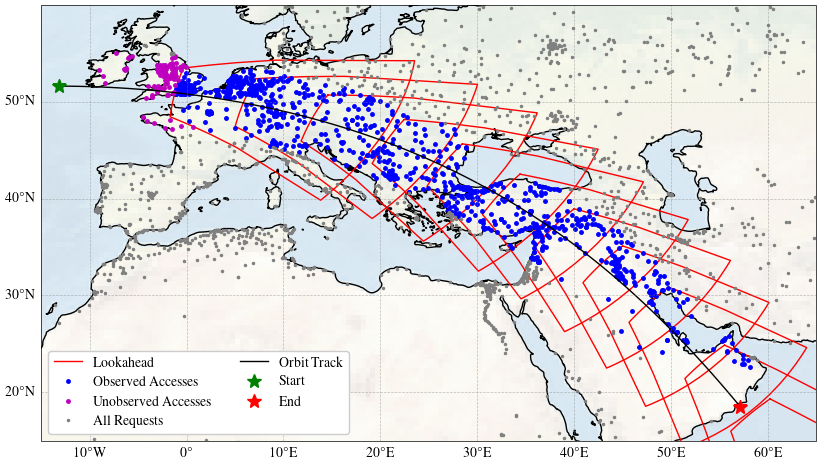

In [71]:
# RL version
import stable_baselines3 as sb3

# Make sure to filter in the states first
def generate_state(accesses, schedule, time, alongtrack_states, crosstrack_states, horizon_time_seconds, field_of_regard):
    # Source data
    times = [(a.time - time).total_seconds() for a in accesses if not a.state["observed"]]
    angles = [a.angle for a in accesses if not a.state["observed"]]

    schedule_times = [(a.time - time).total_seconds() for a in schedule]
    schedule_angles = [a.angle for a in schedule]

    # Convert to 2D histogram
    hist_accesses = np.histogram2d(times, angles, bins=[alongtrack_states, crosstrack_states], range=[[0, horizon_time_seconds], [-field_of_regard, field_of_regard]])
    hist_schedule = np.histogram2d(schedule_times, schedule_angles, bins=[alongtrack_states, crosstrack_states], range=[[0, horizon_time_seconds], [-field_of_regard, field_of_regard]])

    return np.stack([hist_accesses[0].astype(np.float32), hist_schedule[0].astype(np.float32)])

def evaluate_lookahead_rl(model, time, orbit, schedule, accesses, accesses_converted, points, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)

    # Shove the accesses, schedule into the state
    model.policy.eval()

    # Static parameters
    alongtrack_states = 41
    crosstrack_states = 12

    field_of_regard=45
    horizon_time_seconds = horizon_time(orbit)
    
    # Generate the state...
    state = generate_state(accesses, schedule, time, alongtrack_states, crosstrack_states, horizon_time_seconds, field_of_regard)

    action, _= model.predict(state)

    pitch_deg = action[0] * np.rad2deg(horizon_angle(orbit_new))
    roll_deg = 0

    print(pitch_deg, roll_deg)


    accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef)

    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(pitch_deg, roll_deg, orbit_new, K, time, accesses_filtered, points, schedule)

    return pitch_deg, roll_deg, in_box_idx

N = 1

omni_schedule_perf = []
initial_schedule_perf = []
dt_schedule_perf = []

# Create high resolution box with 20 points per edge
box_hires = create_box(width, height, points_per_edge=12)

model = sb3.PPO.load("./exploration/test_with_schedule_ppo_altrewards_35k.zip")
model.policy.eval()

for i in tqdm(range(N)):
    for a in accesses:
        a.state = {"observed": False, "cloudy": np.random.rand() < 0.66}

    schedule = milp_schedule(accesses, requests, agility_bangbang)
    schedule_omni = milp_schedule([a for a in accesses if not a.state["cloudy"]], requests, agility_bangbang)

    print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))
    initial_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))
    omni_schedule_perf.append((len(schedule_omni), len([s for s in schedule_omni if not s.state["cloudy"]])))

    # K = get_intrinsics(800, width//2, height//2)
    K = get_intrinsics_from_fov(45, width, height)

    if(N == 1):
        fig = plt.figure(figsize=(10, 10))
        # Create a cartopy GeoAxes with PlateCarree projection
        ax = plt.axes(projection=ccrs.PlateCarree())
        lookahead_plotted=False

    utilities, advs, costs = [], [], []
    i = 0
    print(schedule[0])
    while(i < len(schedule)):
        s = schedule[i]
        t = s.time
        # Convert all accesses to ECEF
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(accesses)]
        points = np.array([r for r, _, _, _, _ in accesses_converted])

        # Get current orbit position in ECEF
        orbit_new = propagate_orbit(orbit, t)
        r , v = kepler2eci(orbit_new)
        # pos_ecef = eci2ecef(r, t)
        v_ecef = eci2ecef(v, t)
        
        horizon_time_seconds = horizon_time(orbit_new)
        # Filter all within the horizon time
        accesses_horizon = [a for a in accesses if a.time <= t + datetime.timedelta(seconds=horizon_time_seconds)]
        schedule_horizon = [s for s in schedule if s.time <= t + datetime.timedelta(seconds=horizon_time_seconds)]

        lookahead_action = evaluate_lookahead_rl(model, t, orbit_new,schedule_horizon, accesses_horizon, accesses_converted, points, K)

        pitch_deg, roll_deg, in_box_idx = lookahead_action

        # For plotting
        ecef_unprojected_dir = -(r - unproject_from_orbit(box_hires, 1, K, orbit_new, t, pitch_angle=pitch_deg, roll_angle=roll_deg))
        # Calculate Earth line intersections in ECI
        
        eci_intersections = [earth_line_intersection(r, d, horizon_snap=True)[0] for d in ecef_unprojected_dir]
        # Convert to latlong
        latlong_intersections = [ecef2latlong(eci2ecef(i, t)) for i in eci_intersections]
        take_lookahead = pitch_deg > 22.5
        if(take_lookahead):
            # Mark the accesses as observed
            for j in in_box_idx:
                accesses[accesses_converted[j][-1]].state["observed"] = True
            
            # Plot the lookahead
            if(N==1):
                plt.plot([a[1] for a in latlong_intersections], [a[0] for a in latlong_intersections], 'r', transform=ccrs.PlateCarree(), label='Lookahead' if not lookahead_plotted else None)
                lookahead_plotted = True

            # TODO: Re-optimize the schedule...
            min_time = t
            max_time = np.max([a[2] for a in accesses_converted if a[-2].state["observed"]])


            accesses_in_time = [a for a in accesses if a.time >= min_time + datetime.timedelta(seconds=maneuver_time) and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])] 
            # Make sure to add the bounding accesses
            if(schedule[i] not in accesses_in_time):
                accesses_in_time.insert(0, schedule[i])

            max_bounding = [(i, s) for i, s in enumerate(schedule) if s.time >= max_time][0]
            max_bounding_schedule_idx, max_bounding_schedule = max_bounding[0], max_bounding[1]
            if(max_bounding_schedule not in accesses_in_time):
                accesses_in_time.append(max_bounding_schedule)

            # Re-optimize the schedule, force in the bounding accesses
            # print([schedule[i], max_bounding_schedule])
            try:
                schedule_slice_optimized = milp_schedule(accesses_in_time, requests, agility_bangbang, [schedule[i], max_bounding_schedule])
            except Exception as e:
                print(e, [schedule[i], max_bounding_schedule], len(accesses_in_time))
            
            # Update the schedule
            schedule = schedule[:i] + schedule_slice_optimized[1:-1] + schedule[max_bounding_schedule_idx:]
        i += 1

    dt_schedule_perf.append((len(schedule), len([s for s in schedule if not s.state["cloudy"]])))

print(len(schedule), len([s for s in schedule if not s.state["cloudy"]]))

# Plot accesses
plt.plot([a.long for a in accesses if a.state["observed"]], [a.lat for a in accesses if a.state["observed"]], 'b.', transform=ccrs.PlateCarree(), label='Observed Accesses', markersize=5)
plt.plot([a.long for a in accesses if not a.state["observed"]], [a.lat for a in accesses if not a.state["observed"]], 'm.', transform=ccrs.PlateCarree(), label='Unobserved Accesses', markersize=5)
plt.plot([r.long for r in requests if r not in [x.request for x in accesses]], [r.lat for r in requests if r not in [x.request for x in accesses]], '.', transform=ccrs.PlateCarree(), label="All Requests", color='grey', markersize=3)
# May as well plot the orbit track
orbit_latlong = [kepler2latlong(propagate_orbit(orbit, t), orbit.t + datetime.timedelta(seconds=t)) for t in np.linspace(0, (t_end - t0).total_seconds(), 100)]
plt.plot([long for lat, long in orbit_latlong], [lat for lat, long in orbit_latlong], 'k-', label='Orbit Track')

# Show the start and end latlong
orbit_latlong_start = kepler2latlong(propagate_orbit(orbit, 0), t0)
orbit_latlong_end = kepler2latlong(propagate_orbit(orbit, (t_end - t0).total_seconds()), t_end)
print(orbit_latlong_start)
print(orbit_latlong_end)
plt.plot([orbit_latlong_start[1]], [orbit_latlong_start[0]], 'g*', transform=ccrs.PlateCarree(), label='Start', markersize=10)
plt.plot([orbit_latlong_end[1]], [orbit_latlong_end[0]], 'r*', transform=ccrs.PlateCarree(), label='End', markersize=10)

# Add coastlines
ax.stock_img(alpha=0.3)
ax.coastlines()
ax.set_extent([-15, 65, 15, 60], crs=ccrs.PlateCarree())
ax.legend(frameon=True, ncol=2)

# Add gridlines for latitude and longitude
gridlines = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gridlines.top_labels = False    # Disable labels at the top
gridlines.right_labels = False  # Disable labels on the right
plt.savefig('lookahead_chain.png', dpi=300)
plt.show()